In [17]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import numpy as np
import random
import glob

In [18]:
# Chemin vers les fichiers CSV
chemin = '/Users/melusinecaillard/Desktop/players/*.csv'

# Liste des noms de fichiers
fichiers = glob.glob(chemin)

# Initialisation d'une liste pour stocker les DataFrames de chaque fichier
dfs = []
# Liste des encodages à essayer
encodings_to_try = [ 'utf-8','ISO-8859-1']

# Charger et concaténer les fichiers
for fichier in fichiers:
    df = None
    # Essayer différents encodages jusqu'à ce que la lecture réussisse
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(fichier, encoding=encoding)
            print(f"Lecture réussie avec l'encodage {encoding}.")
            break  # Sortir de la boucle si la lecture réussit avec un encodage
        except UnicodeDecodeError:
            print(f"Échec de la lecture avec l'encodage {encoding}. Essayer un autre encodage.")

    if df is not None:
        # Ajouter une colonne 'source' pour identifier la provenance de chaque fichier
        nom_fichier = fichier.split('/')[-1]
        saison = nom_fichier.split('.')[0].split('-')
        df['source'] = f"{saison[0]}-{saison[1]}"
        # Concaténer 'first_name' et 'second_name' en une seule colonne 'name'
        df['name'] = df['first_name'] + ' ' + df['second_name']
        # Supprimer les colonnes 'first_name' et 'second_name'
        df = df.drop(columns=['first_name', 'second_name'])
        # Ajouter le DataFrame à la liste
        dfs.append(df)
    else:
        print("Échec de la lecture du fichier:", fichier)


# Concaténer tous les DataFrames en un seul
data = pd.concat(dfs, ignore_index=True)



# Maintenant vous pouvez faire du traitement de données sur le DataFrame 'data'
# Par exemple, afficher les premières lignes
print(data.info())


Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Échec de la lecture avec l'encodage utf-8. Essayer un autre encodage.
Lecture réussie avec l'encodage ISO-8859-1.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   goals_scored         5606 non-null   int64  
 1   assists              5606 non-null   int64  
 2   total_points         5606 non-null   int64  
 3   minutes              5606 non-null   int64  
 4   goals_conceded       5606 non-null   int64  
 5   creativity           5606 non-null   float64
 6   influence            5606 non-null   float64
 7   threat               5606 non-null   float64
 8   b

In [19]:
# Ingénierie des caractéristiques
selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']
X = data[selected_features]
y = data['total_points']

In [20]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = X_train.select_dtypes(include=['number']).columns

In [22]:
# Vérification des valeurs manquantes dans les données d'entraînement
print("Valeurs manquantes dans y_train:", np.isnan(y_train).sum())

# Vérification des valeurs manquantes dans les données de test
print("Valeurs manquantes dans y_test:", np.isnan(y_test).sum())


Valeurs manquantes dans y_train: 0
Valeurs manquantes dans y_test: 0


In [23]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'l2_regularization': [0.0, 0.1, 0.2]
}


In [24]:
# Create the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

In [25]:
# Train the model
model.fit(X_train, y_train)


HistGradientBoostingRegressor()

In [26]:
# Predict on the test set
y_pred = model.predict(X_test)

In [27]:
# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


Evaluation des performances du modèle

In [28]:
# Effectuer la validation croisée
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')


In [29]:
# Exécuter la recherche par grille sur les données
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'min_samples_leaf': [1, 2, 4]},
             scoring='neg_mean_squared_error')

In [30]:
# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Calculer la moyenne des scores de MSE
avg_mse = -scores.mean()

In [31]:
# Afficher les meilleurs paramètres et la meilleure MSE
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

Meilleurs paramètres: {'l2_regularization': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 2}
Meilleure MSE: 34.78160301569308


In [32]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

# Afficher le score moyen de MSE
print("Moyenne des scores de MSE:", avg_mse)

Mean Squared Error: 33.03430553567649
R-squared: 0.9857973698022744
Mean Absolute Error: 3.469018531795853
Moyenne des scores de MSE: 38.69325786657404


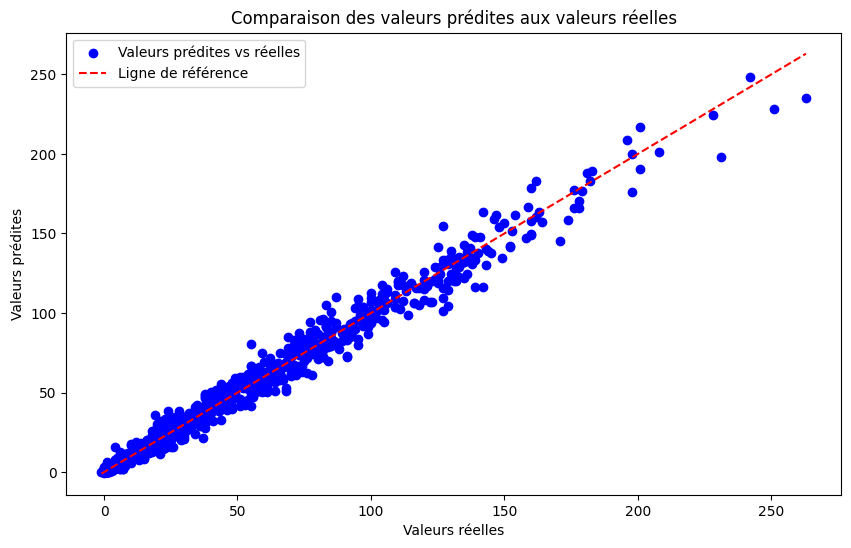

In [33]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [34]:
# Créer un nouveau modèle avec les paramètres optimisés
optimal_model = HistGradientBoostingRegressor(
    l2_regularization=0.0,
    learning_rate=0.1,
    max_depth=5,
    max_iter=300,
    min_samples_leaf=2
)


In [35]:
# Entraîner le nouveau modèle avec les données d'entraînement
optimal_model.fit(X_train, y_train)

HistGradientBoostingRegressor(max_depth=5, max_iter=300, min_samples_leaf=2)

In [36]:
# Prédire sur les données de test
y_pred_optimal = optimal_model.predict(X_test)

In [37]:
# Calculer le RMSE
rmse_optimal = np.sqrt(mean_squared_error(y_test, y_pred_optimal))

# Calculer le MAPE
# Calculer le MAPE en évitant les divisions par zéro
mape_optimal = np.mean(np.abs((y_test - y_pred_optimal) / y_test.replace(0, np.nan))) * 100


In [38]:
# Évaluer les performances du nouveau modèle sur les données de test
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)
mae_optimal = mean_absolute_error(y_test, y_pred_optimal)

In [39]:

# Afficher les performances du nouveau modèle
print("Performances du modèle avec les paramètres optimisés :")
print("MSE:", mse_optimal)
print("R-squared:", r2_optimal)
print("MAE:", mae_optimal)
print("RMSE:", rmse_optimal)
print("MAPE:", mape_optimal)

Performances du modèle avec les paramètres optimisés :
MSE: 33.04935294037537
R-squared: 0.9857909003844705
MAE: 3.4067805653356045
RMSE: 5.748856663752835
MAPE: 20.410655950494


In [40]:
# Afficher les performances du nouveau modèle
print("Performances du modèle avec les paramètres optimisés :")
print("MSE:", mse_optimal)
print("R-squared:", r2_optimal)
print("MAE:", mae_optimal)

Performances du modèle avec les paramètres optimisés :
MSE: 33.04935294037537
R-squared: 0.9857909003844705
MAE: 3.4067805653356045


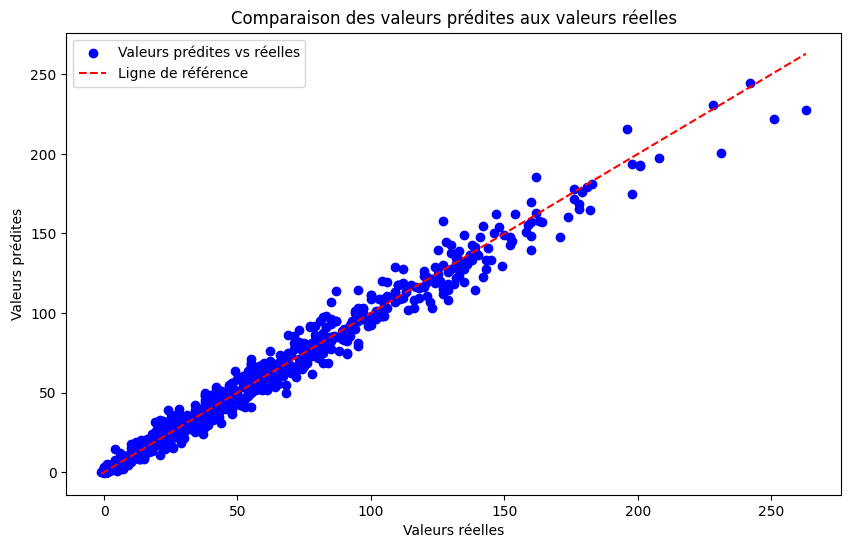

In [41]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimal, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [42]:
print(data.head())

   goals_scored  assists  total_points  minutes  goals_conceded  creativity  \
0             0        0             0        0               0         0.0   
1             0        0             0        0               0         0.0   
2             0        1             4        1               0         0.5   
3             1        3            21      236               2        63.6   
4             0        0            40     1104              12        56.7   

   influence  threat  bonus  bps  ict_index  clean_sheets  red_cards  \
0        0.0     0.0      0    0        0.0             0          0   
1        0.0     0.0      0    0        0.0             0          0   
2        1.8     2.0      0   12        0.4             0          0   
3       79.4    77.0      0   62       21.9             1          1   
4      202.8    69.0      2  210       32.9             4          0   

   yellow_cards  selected_by_percent  now_cost element_type        source  \
0             0

In [44]:
team_data = pd.read_csv('/Users/melusinecaillard/RSPL/data/2023-24/gws/gw16.csv')
team_data = team_data.rename(columns={'value': 'now_cost'})

print(team_data.head())
print(len(team_data))

               name position           team   xP  assists  bonus  bps  \
0       Femi Seriki      DEF  Sheffield Utd -0.5        0      0    0   
1     Josh Brooking      DEF        Chelsea  0.0        0      0    0   
2       Radek Vítek       GK        Man Utd  0.5        0      0    0   
3  Jack Hinshelwood      MID       Brighton  2.9        0      0    0   
4      Jadon Sancho      MID        Man Utd  0.0        0      0    0   

   clean_sheets  creativity  element  ...  team_a_score  team_h_score  threat  \
0             0         0.0      653  ...             0             1     0.0   
1             0         0.0      723  ...             0             2     0.0   
2             0         0.0      669  ...             3             0     0.0   
3             0         0.6      621  ...             1             1    59.0   
4             0         0.0      397  ...             3             0     0.0   

   total_points  transfers_balance  transfers_in  transfers_out  now_cost 

In [45]:
def predict_player_performance(model, player_name, data):
    # Filtrer les données pour obtenir les caractéristiques du joueur spécifié
    player_data = data[data['name'] == player_name]

    # Sélectionner uniquement les caractéristiques utilisées lors de l'entraînement
    selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']


    player_data = player_data[selected_features]

    # Effectuer la prédiction
    predicted_performance = optimal_model.predict(player_data)

    # Calculer la moyenne des performances prédites
    average_performance = np.mean(predicted_performance)

    return average_performance

In [49]:
# Nom du joueur à prédire
player_name = 'Philip Billing'

# Prédiction des performances du joueur
predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

print("Performances prédites (total_points) pour le joueur: ",player_name, predicted_performance)


Performances prédites (total_points) pour le joueur:  Philip Billing 9.01581624726433


In [50]:
# Sélectionner les informations pour le joueur spécifié
player_info = team_data[team_data['name'] == player_name]

# Vérifier si le joueur spécifié est présent dans les données
if not player_info.empty:
    # Extraire les informations nécessaires
    now_cost = player_info['now_cost'].values[0]
    total_points = player_info['total_points'].values[0]
    position = player_info['position'].values[0]  # Assurez-vous que 'element_type' contient les informations sur le poste du joueur

    # Afficher les informations
    print("Nom du joueur:", player_name)
    print("Prix actuel:", now_cost)
    print("Total de points actuel:", total_points)
    print("Poste:", position)
else:
    print("Le joueur spécifié n'a pas été trouvé dans les données.")


Nom du joueur: Philip Billing
Prix actuel: 52
Total de points actuel: 6
Poste: MID


prediction pour les joueurs de la saison en cours

In [51]:

# Créer une liste pour stocker les prédictions de performances pour tous les joueurs de la saison 23-24
all_predictions = []

# Itérer sur chaque joueur dans le DataFrame de la saison 23-24
for player_name in team_data['name']:
    # Prédiction des performances du joueur avec le modèle entraîné
    predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

    # Ajouter le nom du joueur et ses prédictions à la liste
    all_predictions.append((player_name, predicted_performance))

# Afficher les prédictions pour tous les joueurs de la saison 23-24
for player_name, predicted_performance in all_predictions:
    print("Performances prédites (total_points) pour le joueur:", player_name, ":", predicted_performance)


Performances prédites (total_points) pour le joueur: Femi Seriki : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Josh Brooking : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Radek Vítek : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Jack Hinshelwood : 2.9392647658118958
Performances prédites (total_points) pour le joueur: Jadon Sancho : -0.07878916825308502
Performances prédites (total_points) pour le joueur: Divock Origi : 0.16424948896928615
Performances prédites (total_points) pour le joueur: Rhys Norrington-Davies : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Vitaly Janelt : 3.86989290659729
Performances prédites (total_points) pour le joueur: Ionuț Radu : 0.15660605401796962
Performances prédites (total_points) pour le joueur: Andre Brooks : 5.08548173248087
Performances prédites (total_points) pour le joueur: Jack Grealish : 11.795280810315957
Performances prédi

In [52]:
print(len(all_predictions))

758


In [53]:
# Créer un dictionnaire à partir de la liste de toutes les prédictions
predicted_performances_dict = {player_name: predicted_performance for player_name, predicted_performance in all_predictions}


Création d'une equipe

In [54]:
def create_team(predicted_performances, data, budget=100, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    team_players_count = {}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        # Vérifier si l'équipe a déjà atteint le nombre maximum de joueurs
        if len(team) >= 15:
            break

        # Vérifier si le joueur est présent dans les données
        player_data = data[data['name'] == player_name]
        if not player_data.empty:
            player_cost = player_data['now_cost'].values[0]
            player_position = player_data['position'].values[0]
            player_team = player_data['team'].values[0]

            # Vérification des contraintes de budget, de nombre maximum de joueurs par équipe et de quota par poste
            if player_cost <= remaining_budget and team_players_count.get(player_team, 0) < max_players_per_team and positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                positions_count[player_position] += 1
                team_players_count[player_team] = team_players_count.get(player_team, 0) + 1

    return team


In [55]:
# Créer une équipe en utilisant les performances prédites
team = create_team(predicted_performances_dict, team_data, budget=1000, max_players_per_team=3)

In [56]:
# Afficher l'équipe sélectionnée
print("Équipe sélectionnée:")
for player in team:
    print(f"Nom: {player['name']}, Poste: {player['position']}, Équipe: {player['team']}, Coût: {player['cost']}, Performance Prédite: {player['predicted_performance']}")


Équipe sélectionnée:
Nom: Son Heung-min, Poste: MID, Équipe: Spurs, Coût: 96, Performance Prédite: 21.399111399312105
Nom: Richarlison de Andrade, Poste: MID, Équipe: Spurs, Coût: 66, Performance Prédite: 18.48123443920375
Nom: Simon Adingra, Poste: MID, Équipe: Brighton, Coût: 50, Performance Prédite: 17.397506200896927
Nom: Tosin Adarabioyo, Poste: DEF, Équipe: Fulham, Coût: 43, Performance Prédite: 15.276258748195692
Nom: Marcos Senesi, Poste: DEF, Équipe: Bournemouth, Coût: 43, Performance Prédite: 15.251077300287578
Nom: Raúl Jiménez, Poste: FWD, Équipe: Fulham, Coût: 52, Performance Prédite: 15.145423493513514
Nom: Bernardo Veiga de Carvalho e Silva, Poste: MID, Équipe: Man City, Coût: 64, Performance Prédite: 15.073579559038103
Nom: John McGinn, Poste: MID, Équipe: Aston Villa, Coût: 55, Performance Prédite: 14.965142028238066
Nom: Matheus Santos Carneiro Da Cunha, Poste: FWD, Équipe: Wolves, Coût: 56, Performance Prédite: 14.507156536377023
Nom: Dominic Solanke, Poste: FWD, Équ

In [57]:
# Calcul du prix total de l'équipe recommandée
total_cost = sum(player['cost'] for player in team)
total_team_points = sum(player['predicted_performance'] for player in team)
print("Le cout total de l'equipe est de:", total_cost, "k£")
print("Le nombre de point total de l'equipe est de:", total_team_points)

Le cout total de l'equipe est de: 864 k£
Le nombre de point total de l'equipe est de: 207.7769184309247


In [58]:

# Affichage de la composition de l'équipe recommandée
print("Composition de l'équipe recommandée:")
for player in team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()

Composition de l'équipe recommandée:
Joueur: Son Heung-min
Poste: MID
Équipe: Spurs
Prix: 96 k£
Score prédit: 21.399111399312105

Joueur: Richarlison de Andrade
Poste: MID
Équipe: Spurs
Prix: 66 k£
Score prédit: 18.48123443920375

Joueur: Simon Adingra
Poste: MID
Équipe: Brighton
Prix: 50 k£
Score prédit: 17.397506200896927

Joueur: Tosin Adarabioyo
Poste: DEF
Équipe: Fulham
Prix: 43 k£
Score prédit: 15.276258748195692

Joueur: Marcos Senesi
Poste: DEF
Équipe: Bournemouth
Prix: 43 k£
Score prédit: 15.251077300287578

Joueur: Raúl Jiménez
Poste: FWD
Équipe: Fulham
Prix: 52 k£
Score prédit: 15.145423493513514

Joueur: Bernardo Veiga de Carvalho e Silva
Poste: MID
Équipe: Man City
Prix: 64 k£
Score prédit: 15.073579559038103

Joueur: John McGinn
Poste: MID
Équipe: Aston Villa
Prix: 55 k£
Score prédit: 14.965142028238066

Joueur: Matheus Santos Carneiro Da Cunha
Poste: FWD
Équipe: Wolves
Prix: 56 k£
Score prédit: 14.507156536377023

Joueur: Dominic Solanke
Poste: FWD
Équipe: Bournemouth
Pr